In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import bisect
import seaborn as sns
# 데이터 로드
data = pd.read_csv('train_notnull(mean).csv').drop(columns=['SAMPLE_ID'])
data.shape

### 데이터 설명
# train_notnull(mean) : 결측치는 모두 항구별 평균으로 대체, 항구 1곳(RGT8)의 해당 행 데이터 삭제, 
#                       배 연령(BUILT) 이상치값을 30(upper_bound = q3 + (iqr * 1.5))으로 수정한 데이터
# drop 한 컬럼 : 범주형 데이터

(391933, 22)

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391933 entries, 0 to 391932
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              391933 non-null  object 
 1   ARI_PO              391933 non-null  object 
 2   SHIP_TYPE_CATEGORY  391933 non-null  object 
 3   DIST                391933 non-null  float64
 4   ATA                 391933 non-null  object 
 5   ID                  391933 non-null  object 
 6   BREADTH             391933 non-null  float64
 7   BUILT               391933 non-null  int64  
 8   DEADWEIGHT          391933 non-null  int64  
 9   DEPTH               391933 non-null  float64
 10  DRAUGHT             391933 non-null  float64
 11  GT                  391933 non-null  int64  
 12  LENGTH              391933 non-null  float64
 13  SHIPMANAGER         391933 non-null  object 
 14  FLAG                391933 non-null  object 
 15  U_WIND              391933 non-nul

In [3]:
columns = ['DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT' , 'LENGTH', 
           'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN' ,'ATA_LT', 'PORT_SIZE', 'CI_HOUR']

df_small = data[columns]
df_corr = df_small.corr()
df_corr

,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
DIST,1.000000,0.025350,-0.004782,0.025490,-0.001037,0.031941,0.015960,0.025210,-0.042285,0.056767,-0.019500,-0.035524,-0.000011,0.191330,0.189144
BREADTH,0.025350,1.000000,-0.204533,0.857126,0.790474,0.761335,0.903984,0.920649,-0.060767,0.026664,0.137545,0.102312,0.005998,0.036766,0.043705
BUILT,-0.004782,-0.204533,1.000000,-0.241026,-0.202256,-0.144055,-0.238120,-0.174885,0.003801,-0.015104,-0.013497,-0.017766,-0.008506,0.048766,-0.004259
DEADWEIGHT,0.025490,0.857126,-0.241026,1.000000,0.712964,0.813403,0.925142,0.826763,-0.032079,0.046340,0.092960,0.113472,0.007765,-0.138995,0.077950
DEPTH,-0.001037,0.790474,-0.202256,0.712964,1.000000,0.581058,0.787591,0.842636,-0.050543,0.032991,0.082333,0.087723,0.004849,0.019597,0.051755
DRAUGHT,0.031941,0.761335,-0.144055,0.813403,0.581058,1.000000,0.779029,0.737615,-0.036624,0.032184,0.096726,0.105171,0.005970,-0.043581,0.040308
GT,0.015960,0.903984,-0.238120,0.925142,0.787591,0.779029,1.000000,0.916683,-0.049519,0.025152,0.113928,0.092616,0.005591,0.018286,0.059657
LENGTH,0.025210,0.920649,-0.174885,0.826763,0.842636,0.737615,0.916683,1.000000,-0.062963,0.024642,0.129184,0.092963,0.005403,0.085292,0.035328
U_WIND,-0.042285,-0.060767,0.003801,-0.032079,-0.050543,-0.036624,-0.049519,-0.062963,1.000000,0.107811,-0.127241,-0.103994,-0.011161,-0.087136,-0.013006
V_WIND,0.056767,0.026664,-0.015104,0.046340,0.032991,0.032184,0.025152,0.024642,0.107811,1.000000,0.159035,-0.191470,0.008170,-0.008754,0.022046


In [4]:
df_corr['CI_HOUR']

DIST               0.189144
BREADTH            0.043705
BUILT             -0.004259
DEADWEIGHT         0.077950
DEPTH              0.051755
DRAUGHT            0.040308
GT                 0.059657
LENGTH             0.035328
U_WIND            -0.013006
V_WIND             0.022046
AIR_TEMPERATURE    0.037995
BN                -0.023450
ATA_LT             0.000093
PORT_SIZE          0.020630
CI_HOUR            1.000000
Name: CI_HOUR, dtype: float64

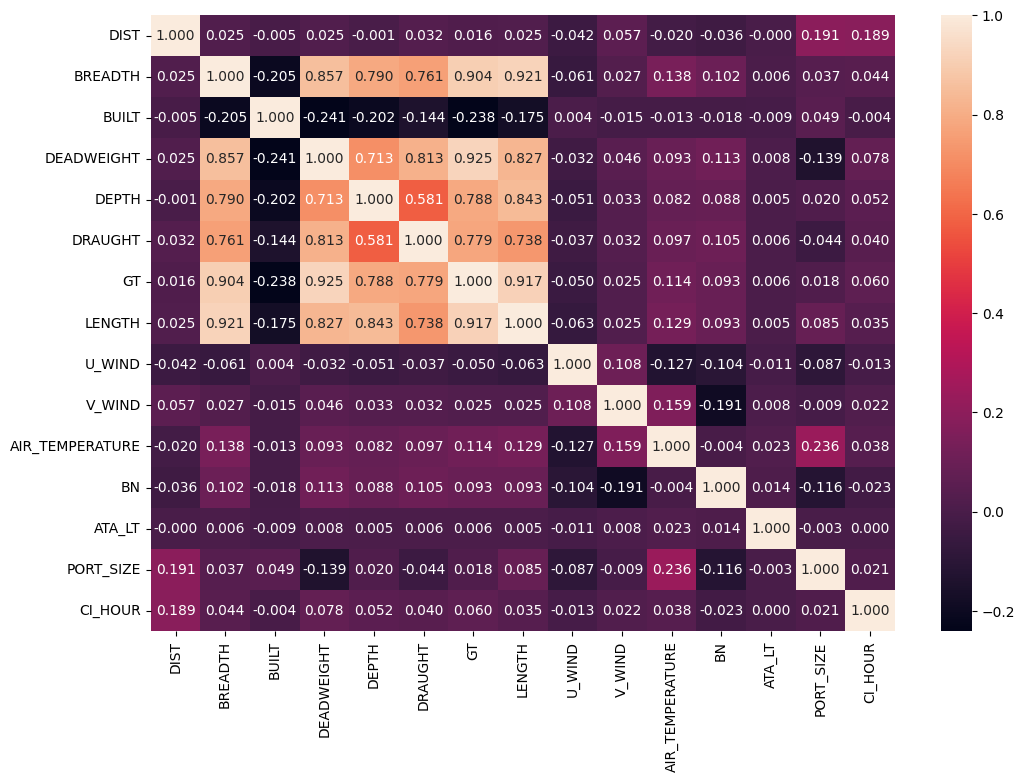

In [5]:
plt.figure(figsize=(12,8))
sns.heatmap(df_corr, annot=True, fmt='.3f')
plt.savefig('./heatmap_수치.png',bbox_inches='tight')

In [6]:
columns = ['DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT' , 'LENGTH', 
           'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN' ,'ATA_LT', 'PORT_SIZE', 'CI_HOUR']

df_small = data[columns]
df_corr = df_small.corr(method='spearman')
df_corr

,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
DIST,1.000000,0.069875,-0.021344,0.097845,0.050011,0.099034,0.074771,0.058391,-0.051130,0.111771,0.022967,-0.002686,-0.005213,0.081873,0.818395
BREADTH,0.069875,1.000000,-0.181561,0.919080,0.793701,0.714722,0.939469,0.923686,-0.068068,0.037639,0.135754,0.132928,0.007679,-0.035128,0.059220
BUILT,-0.021344,-0.181561,1.000000,-0.218003,-0.182167,-0.136825,-0.210323,-0.151577,-0.000156,-0.028133,-0.005462,-0.016122,-0.007781,0.092551,-0.034167
DEADWEIGHT,0.097845,0.919080,-0.218003,1.000000,0.858619,0.722841,0.979446,0.948185,-0.043888,0.066864,0.089756,0.149956,0.009144,-0.150570,0.118959
DEPTH,0.050011,0.793701,-0.182167,0.858619,1.000000,0.542128,0.877486,0.867659,-0.057883,0.043667,0.083111,0.117103,0.006337,-0.041154,0.054703
DRAUGHT,0.099034,0.714722,-0.136825,0.722841,0.542128,1.000000,0.711484,0.688220,-0.026749,0.041819,0.095890,0.136117,0.007158,-0.093274,0.099561
GT,0.074771,0.939469,-0.210323,0.979446,0.877486,0.711484,1.000000,0.984359,-0.063595,0.048013,0.113101,0.135624,0.008246,-0.061980,0.072962
LENGTH,0.058391,0.923686,-0.151577,0.948185,0.867659,0.688220,0.984359,1.000000,-0.071865,0.033613,0.123223,0.125675,0.006783,-0.008125,0.041806
U_WIND,-0.051130,-0.068068,-0.000156,-0.043888,-0.057883,-0.026749,-0.063595,-0.071865,1.000000,0.073720,-0.117067,-0.108442,-0.012250,-0.145490,-0.012320
V_WIND,0.111771,0.037639,-0.028133,0.066864,0.043667,0.041819,0.048013,0.033613,0.073720,1.000000,0.149221,-0.140045,0.006675,-0.065998,0.104183


In [7]:
df_corr['CI_HOUR']

DIST               0.818395
BREADTH            0.059220
BUILT             -0.034167
DEADWEIGHT         0.118959
DEPTH              0.054703
DRAUGHT            0.099561
GT                 0.072962
LENGTH             0.041806
U_WIND            -0.012320
V_WIND             0.104183
AIR_TEMPERATURE    0.042490
BN                -0.006517
ATA_LT             0.002261
PORT_SIZE         -0.074837
CI_HOUR            1.000000
Name: CI_HOUR, dtype: float64

In [8]:
# datetime 컬럼 처리
data['ATA'] = pd.to_datetime(data['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [data]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
data.drop(columns='ATA', inplace=True)

In [9]:
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    data[feature] = le.fit_transform(data[feature].astype(str))
    le_classes_set = set(le.classes_)
    # test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    # test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

Encoding features: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 19.25it/s]


In [10]:
df_corr = data.corr(method='spearman')
df_corr

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,BN,ATA_LT,PORT_SIZE,CI_HOUR,year,month,day,hour,minute,weekday
ARI_CO,1.000000,-0.258764,0.320481,-0.237020,-0.005332,-0.269902,0.115213,-0.346890,-0.253352,-0.278112,...,-0.174225,-0.014251,0.205084,-0.181452,0.096492,-0.015632,-0.000983,0.002479,0.029438,-0.046173
ARI_PO,-0.258764,1.000000,-0.172801,0.059995,0.010633,-0.023091,-0.029979,0.025316,-0.026095,0.037460,...,-0.068207,0.004033,-0.354305,0.065027,0.018976,0.011718,0.001118,0.006299,-0.005065,0.022652
SHIP_TYPE_CATEGORY,0.320481,-0.172801,1.000000,-0.108749,-0.001365,-0.242953,0.133550,-0.427143,-0.275973,-0.261513,...,-0.129249,-0.004849,0.523591,-0.228577,0.096159,-0.059914,0.001346,0.001656,0.071207,-0.056025
DIST,-0.237020,0.059995,-0.108749,1.000000,-0.003293,0.069875,-0.021344,0.097845,0.050011,0.099034,...,-0.002686,-0.005213,0.081873,0.818395,0.040900,-0.010243,0.003613,0.006874,0.003511,0.129770
ID,-0.005332,0.010633,-0.001365,-0.003293,1.000000,-0.004258,-0.001144,-0.003763,-0.006679,0.001066,...,-0.011545,0.000481,-0.005578,-0.004878,-0.005221,-0.000096,0.001476,-0.001531,-0.000891,-0.001789
BREADTH,-0.269902,-0.023091,-0.242953,0.069875,-0.004258,1.000000,-0.181561,0.919080,0.793701,0.714722,...,0.132928,0.007679,-0.035128,0.059220,-0.210809,0.010357,-0.003247,-0.013100,-0.050806,0.013048
BUILT,0.115213,-0.029979,0.133550,-0.021344,-0.001144,-0.181561,1.000000,-0.218003,-0.182167,-0.136825,...,-0.016122,-0.007781,0.092551,-0.034167,-0.131919,-0.001136,-0.000144,0.010379,-0.025228,-0.013879
DEADWEIGHT,-0.346890,0.025316,-0.427143,0.097845,-0.003763,0.919080,-0.218003,1.000000,0.858619,0.722841,...,0.149956,0.009144,-0.150570,0.118959,-0.208414,0.017406,-0.003093,-0.013408,-0.051839,0.026689
DEPTH,-0.253352,-0.026095,-0.275973,0.050011,-0.006679,0.793701,-0.182167,0.858619,1.000000,0.542128,...,0.117103,0.006337,-0.041154,0.054703,-0.174427,0.010893,-0.003622,-0.004987,-0.045848,0.010001
DRAUGHT,-0.278112,0.037460,-0.261513,0.099034,0.001066,0.714722,-0.136825,0.722841,0.542128,1.000000,...,0.136117,0.007158,-0.093274,0.099561,-0.159667,0.010994,-0.003860,-0.022739,-0.037614,0.022332


In [11]:
df_corr['CI_HOUR']

# 제거할 컬럼 : ID, SHIPMANAGER, BN, ATA_LT, month, day, hour, minute
# 사용할 컬럼 : ARI_CO, ARI_PO, SHIP_TYPE_CATEGORY, DIST, BREADTH, BUILT, DEADWEIGHT, DEPTH, DRAUGHT, GT, LENGTH,
#              FLAG, U_WIND, V_WIND, AIR_TEMPERATURE, PORT_SIZE, year, weekday 

ARI_CO               -0.181452
ARI_PO                0.065027
SHIP_TYPE_CATEGORY   -0.228577
DIST                  0.818395
ID                   -0.004878
BREADTH               0.059220
BUILT                -0.034167
DEADWEIGHT            0.118959
DEPTH                 0.054703
DRAUGHT               0.099561
GT                    0.072962
LENGTH                0.041806
SHIPMANAGER           0.009024
FLAG                  0.019671
U_WIND               -0.012320
V_WIND                0.104183
AIR_TEMPERATURE       0.042490
BN                   -0.006517
ATA_LT                0.002261
PORT_SIZE            -0.074837
CI_HOUR               1.000000
year                  0.066205
month                -0.001370
day                   0.000727
hour                  0.005498
minute                0.012081
weekday               0.187938
Name: CI_HOUR, dtype: float64

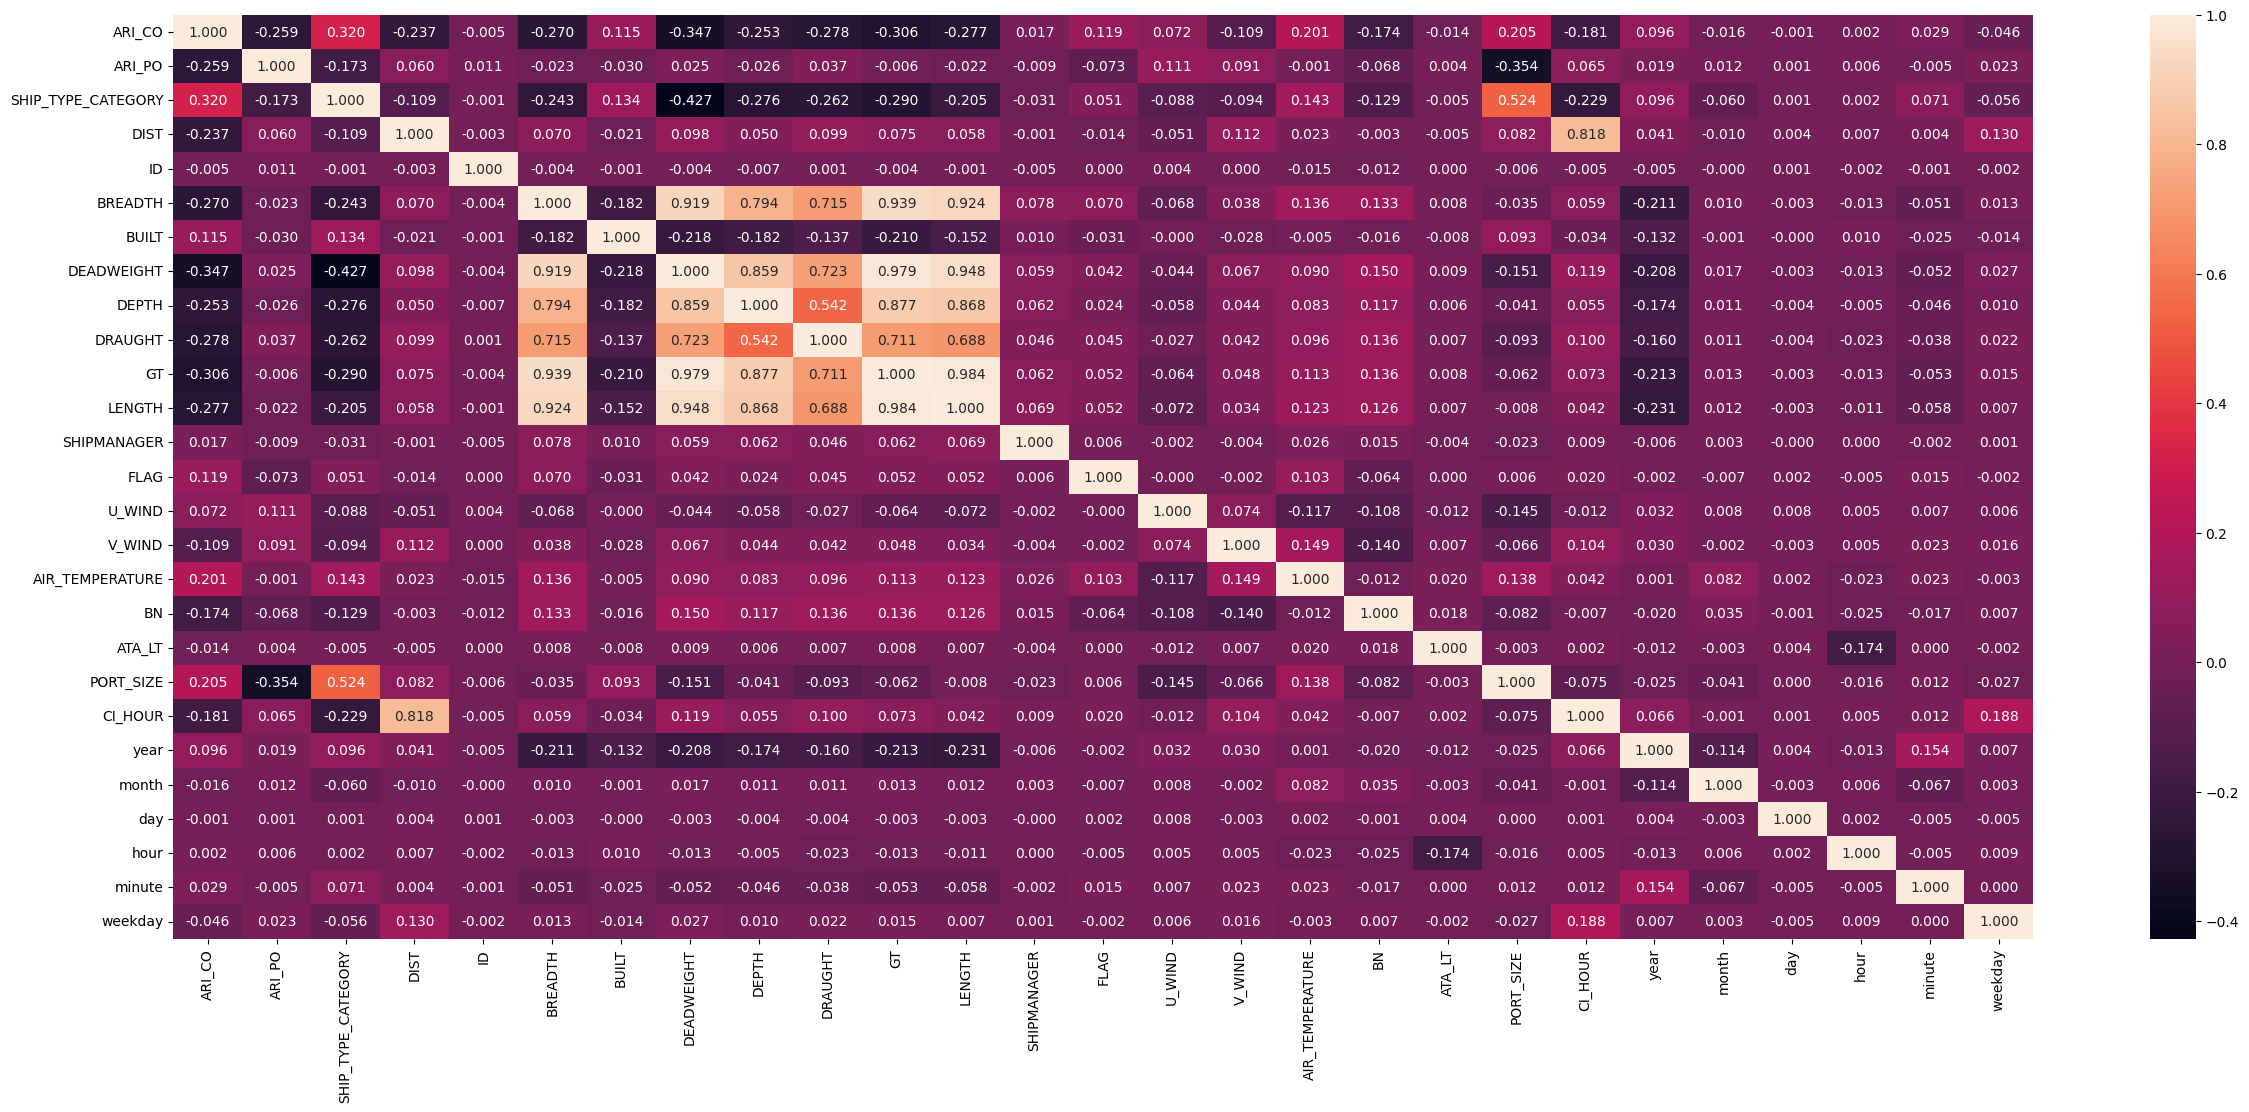

In [12]:
plt.figure(figsize=(30,12))
sns.heatmap(df_corr, annot=True, fmt='.3f')
plt.savefig('./heatmap_범주.png',bbox_inches='tight')

In [13]:
from scipy.stats import pearsonr

# 데이터 생성
X = data[['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH', 
            'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'PORT_SIZE', 'year', 'weekday']]
y = data['CI_HOUR']

In [14]:
import statsmodels.api as sm

# OLS 모델을 만들고 데이터에 맞추기
X_with_intercept = sm.add_constant(X)  # 절편(intercept)을 위해 상수 열을 추가
model = sm.OLS(y, X_with_intercept)
result = model.fit()

# 결과 요약
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                CI_HOUR   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     1590.
Date:                Sun, 07 Apr 2024   Prob (F-statistic):               0.00
Time:                        14:27:21   Log-Likelihood:            -2.5571e+06
No. Observations:              391933   AIC:                         5.114e+06
Df Residuals:                  391914   BIC:                         5.114e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -3090.9744    234

In [15]:
"""
<해석>
p-value가 유의수준보다 작으면 해당 변수는 통계적으로 유의미한 것으로 간주됩니다.

Standard Errors assume that the covariance matrix of the errors is correctly specified:
이 메시지는 표준 오차(Standard Errors)가 오차의 공분산 행렬(covariance matrix)이 올바르게 지정되었다고 가정한다는 것을 나타냅니다. 
즉, 회귀 모형의 가정 중 하나인 오차의 독립성과 등분산성이 충족되었다고 가정합니다. 만약 이 가정이 위배된다면 표준 오차의 추정이 왜곡될 수 있습니다.

The condition number is large, 1.73e+08. This might indicate that there are strong multicollinearity or other numerical problems:
이 메시지는 조건수(condition number)가 크다는 것을 나타냅니다. 조건수는 회귀 모델에서 독립 변수들 간의 상관관계를 측정하는 지표로, 
이 값이 크면 다중공선성(multicollinearity)이나 다른 수치적인 문제가 있을 수 있다는 것을 의미합니다.
다중공선성은 회귀 분석에서 독립 변수들 간에 강한 선형 관계가 있는 경우 발생합니다. 
이는 모델의 해석을 어렵게 만들고 모델의 성능을 저하시킬 수 있습니다. 따라서 조건수가 큰 경우 다중공선성을 의심해볼 필요가 있습니다.
"""

'\n<해석>\np-value가 유의수준보다 작으면 해당 변수는 통계적으로 유의미한 것으로 간주됩니다.\n\nStandard Errors assume that the covariance matrix of the errors is correctly specified:\n이 메시지는 표준 오차(Standard Errors)가 오차의 공분산 행렬(covariance matrix)이 올바르게 지정되었다고 가정한다는 것을 나타냅니다. \n즉, 회귀 모형의 가정 중 하나인 오차의 독립성과 등분산성이 충족되었다고 가정합니다. 만약 이 가정이 위배된다면 표준 오차의 추정이 왜곡될 수 있습니다.\n\nThe condition number is large, 1.73e+08. This might indicate that there are strong multicollinearity or other numerical problems:\n이 메시지는 조건수(condition number)가 크다는 것을 나타냅니다. 조건수는 회귀 모델에서 독립 변수들 간의 상관관계를 측정하는 지표로, \n이 값이 크면 다중공선성(multicollinearity)이나 다른 수치적인 문제가 있을 수 있다는 것을 의미합니다.\n다중공선성은 회귀 분석에서 독립 변수들 간에 강한 선형 관계가 있는 경우 발생합니다. \n이는 모델의 해석을 어렵게 만들고 모델의 성능을 저하시킬 수 있습니다. 따라서 조건수가 큰 경우 다중공선성을 의심해볼 필요가 있습니다.\n'